In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [2]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import os
import pandas as pd

healthy_dirs = [
    r'/kaggle/input/osteoporosis-database/Osteoporosis Knee X-ray/normal',
    r'/kaggle/input/osteoporosis-knee-xray-dataset/normal/normal',
    r'/kaggle/input/osteoporosis-knee-dataset-preprocessed128x256/Osteoporosis Knee Dataset/Normal',
    r'/kaggle/input/osteoporosis/osteoporosis/normal'
]

osteoporosis_dirs = [
    r'/kaggle/input/osteoporosis-database/Osteoporosis Knee X-ray/osteoporosis',
    r'/kaggle/input/osteoporosis-knee-xray-dataset/osteoporosis/osteoporosis',
    r'/kaggle/input/osteoporosis-knee-dataset-preprocessed128x256/Osteoporosis Knee Dataset/Osteoporosis',
    r'/kaggle/input/osteoporosis/osteoporosis/osteoporosis'
]

filepaths = []
labels = []
dict_lists = [healthy_dirs, osteoporosis_dirs]
class_labels = ['Healthy', 'Osteoporosis']


for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
knee_osteoporosis_data = pd.concat([Fseries, Lseries], axis=1)

print(knee_osteoporosis_data.head())
print(knee_osteoporosis_data["labels"].value_counts())

                                           filepaths   labels
0  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
1  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
2  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
3  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
4  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
labels
Osteoporosis    793
Healthy         780
Name: count, dtype: int64


In [4]:
knee_osteoporosis_data.shape

(1573, 2)

In [5]:


train_data, remaining_data = train_test_split(knee_osteoporosis_data, test_size=0.2, random_state=42)
test_data, val_data = train_test_split(remaining_data, test_size=0.5, random_state=42)

In [6]:
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(1258, 2)
(157, 2)
(158, 2)


In [7]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_data,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=4,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_data,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=4,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_data,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=4,
                                    shuffle=False
                                   )

Found 1258 validated image filenames belonging to 2 classes.
Found 157 validated image filenames belonging to 2 classes.
Found 158 validated image filenames belonging to 2 classes.


In [8]:

classes=list(train.class_indices.keys())
print (classes)

['Healthy', 'Osteoporosis']


In [9]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
      
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
       
        index=np.argmax(labels[i]) 
        class_name=classes[index] 
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

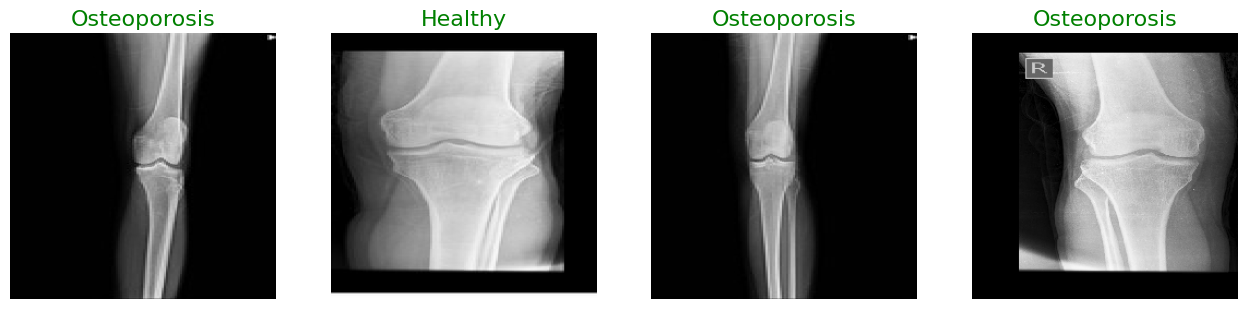

In [10]:
show_knee_images(train)

In [11]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, BatchNormalization, Dropout
from keras.models import Model
from tensorflow.keras.applications import ResNet50
import tensorflow as tf

resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = resnet50_model.output

# Add your custom layers according to your specified architecture
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)

x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding="same")(x)

x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)

x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = Conv2D(512, (3, 3), activation="relu", padding="same")(x) 
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding="same")(x)

x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x) 
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x) 

output = Dense(2, activation="sigmoid")(x)

# Create the custom model
model = Model(inputs=resnet50_model.input, outputs=output)

# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)
model.summary()


94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [12]:
history = model.fit(train, epochs=25, validation_data=val, verbose=1)

Epoch 1/25
315/315 [==============================] - 76s 99ms/step - loss: 0.8496 - accuracy: 0.5111 - val_loss: 0.7957 - val_accuracy: 0.5886
Epoch 2/25
315/315 [==============================] - 23s 73ms/step - loss: 0.8520 - accuracy: 0.5072 - val_loss: 1.0512 - val_accuracy: 0.5253
Epoch 3/25
315/315 [==============================] - 23s 74ms/step - loss: 0.7863 - accuracy: 0.5469 - val_loss: 0.7124 - val_accuracy: 0.5823
Epoch 4/25
315/315 [==============================] - 23s 73ms/step - loss: 0.7461 - accuracy: 0.5898 - val_loss: 0.6609 - val_accuracy: 0.5759
Epoch 5/25
315/315 [==============================] - 23s 73ms/step - loss: 0.7186 - accuracy: 0.5843 - val_loss: 0.6249 - val_accuracy: 0.6646
Epoch 6/25
315/315 [==============================] - 23s 73ms/step - loss: 0.6799 - accuracy: 0.6399 - val_loss: 0.5512 - val_accuracy: 0.7342
Epoch 7/25
315/315 [==============================] - 23s 73ms/step - loss: 0.6799 - accuracy: 0.6399 - val_loss: 0.5784 - val_accuracy:

In [13]:
history1 = model.fit(train, epochs=25, validation_data=val, verbose=1)

Epoch 1/25
315/315 [==============================] - 23s 73ms/step - loss: 0.2977 - accuracy: 0.8847 - val_loss: 0.3401 - val_accuracy: 0.8734
Epoch 2/25
315/315 [==============================] - 23s 73ms/step - loss: 0.2815 - accuracy: 0.8800 - val_loss: 0.3840 - val_accuracy: 0.8797
Epoch 3/25
315/315 [==============================] - 23s 74ms/step - loss: 0.2668 - accuracy: 0.8943 - val_loss: 0.4725 - val_accuracy: 0.8291
Epoch 4/25
315/315 [==============================] - 23s 73ms/step - loss: 0.2749 - accuracy: 0.8816 - val_loss: 0.5371 - val_accuracy: 0.7975
Epoch 5/25
315/315 [==============================] - 23s 74ms/step - loss: 0.2472 - accuracy: 0.9038 - val_loss: 0.3464 - val_accuracy: 0.8734
Epoch 6/25
315/315 [==============================] - 23s 73ms/step - loss: 0.2635 - accuracy: 0.8863 - val_loss: 0.4063 - val_accuracy: 0.8228
Epoch 7/25
315/315 [==============================] - 23s 73ms/step - loss: 0.2660 - accuracy: 0.8919 - val_loss: 0.4457 - val_accuracy:

In [14]:
model.evaluate(test, verbose=1)

40/40 [==============================] - 3s 84ms/step - loss: 0.6937 - accuracy: 0.8025


[0.6937295794487, 0.8025477528572083]

In [15]:
history2 = model.fit(train, epochs=25, validation_data=val, verbose=1)

Epoch 1/25
315/315 [==============================] - 23s 73ms/step - loss: 0.0498 - accuracy: 0.9857 - val_loss: 0.4905 - val_accuracy: 0.8354
Epoch 2/25
315/315 [==============================] - 23s 73ms/step - loss: 0.0853 - accuracy: 0.9666 - val_loss: 0.6121 - val_accuracy: 0.7785
Epoch 3/25
315/315 [==============================] - 23s 74ms/step - loss: 0.0881 - accuracy: 0.9658 - val_loss: 0.6145 - val_accuracy: 0.8165
Epoch 4/25
315/315 [==============================] - 23s 72ms/step - loss: 0.0659 - accuracy: 0.9777 - val_loss: 0.5826 - val_accuracy: 0.8481
Epoch 5/25
315/315 [==============================] - 23s 72ms/step - loss: 0.0447 - accuracy: 0.9849 - val_loss: 0.4803 - val_accuracy: 0.8354
Epoch 6/25
315/315 [==============================] - 23s 73ms/step - loss: 0.0318 - accuracy: 0.9881 - val_loss: 0.5107 - val_accuracy: 0.8544
Epoch 7/25
315/315 [==============================] - 23s 72ms/step - loss: 0.0340 - accuracy: 0.9889 - val_loss: 0.5763 - val_accuracy:

In [16]:
model.evaluate(test, verbose=1)

40/40 [==============================] - 2s 51ms/step - loss: 0.7368 - accuracy: 0.8535


[0.7368168830871582, 0.8535031676292419]

In [25]:
history3 = model.fit(train, epochs=25, validation_data=val, verbose=1)

Epoch 1/25
315/315 [==============================] - 23s 73ms/step - loss: 0.0396 - accuracy: 0.9873 - val_loss: 0.4217 - val_accuracy: 0.8671
Epoch 6/25
315/315 [==============================] - 23s 74ms/step - loss: 0.0138 - accuracy: 0.9984 - val_loss: 0.4355 - val_accuracy: 0.8544
Epoch 7/25
315/315 [==============================] - 23s 73ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.4404 - val_accuracy: 0.8797
Epoch 8/25
315/315 [==============================] - 23s 72ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.4862 - val_accuracy: 0.8734
Epoch 9/25
315/315 [==============================] - 23s 73ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.5112 - val_accuracy: 0.8671
Epoch 10/25
315/315 [==============================] - 24s 75ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.5073 - val_accuracy: 0.8734
Epoch 11/25
315/315 [==============================] - 23s 73ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.5183 - val_accurac

In [26]:
model.evaluate(test, verbose=1)

40/40 [==============================] - 2s 51ms/step - loss: 0.8619 - accuracy: 0.8217


[0.8619059920310974, 0.8216560482978821]

In [27]:
model.save("Osteoporosis_Model_binary.h5")

In [28]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

40/40 [==============================] - 2s 48ms/step


In [29]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, recall_score

y_test = test_data.labels # set y_test to the expected output
print(classification_report(y_test, pred2, digits=5))
print("Accuracy of the Model: {:.5f}".format(accuracy_score(y_test, pred2)))
precision = precision_score(y_test, pred2, average='weighted')
print("Precision of the Model: {:.5f}".format(precision))
recall = recall_score(y_test, pred2, average='weighted')
print("Recall Score of the Model: {:.5f}".format(recall))
f1 = f1_score(y_test, pred2, average='weighted')
print("f1 Score of the Model: {:.5f}".format(f1))

              precision    recall  f1-score   support

     Healthy    0.81481   0.83544   0.82500        79
Osteoporosis    0.82895   0.80769   0.81818        78

    accuracy                        0.82166       157
   macro avg    0.82188   0.82157   0.82159       157
weighted avg    0.82184   0.82166   0.82161       157

Accuracy of the Model: 0.82166
Precision of the Model: 0.82184
Recall Score of the Model: 0.82166
f1 Score of the Model: 0.82161


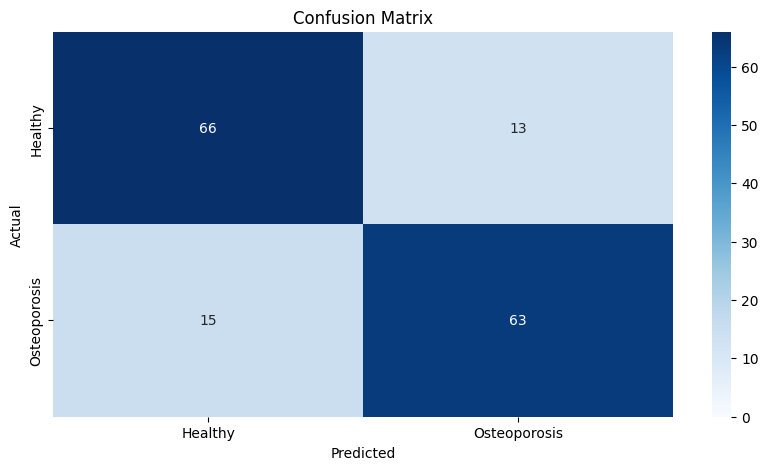

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['Healthy','Osteoporosis']

cm = confusion_matrix(y_test, pred2)

plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

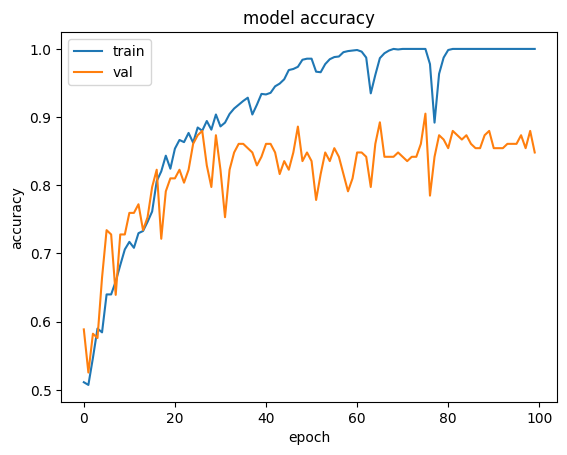

In [31]:
plt.plot(history.history['accuracy'] + history1.history['accuracy'] + history2.history['accuracy'] + history3.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history1.history['val_accuracy'] + history2.history['val_accuracy'] + history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

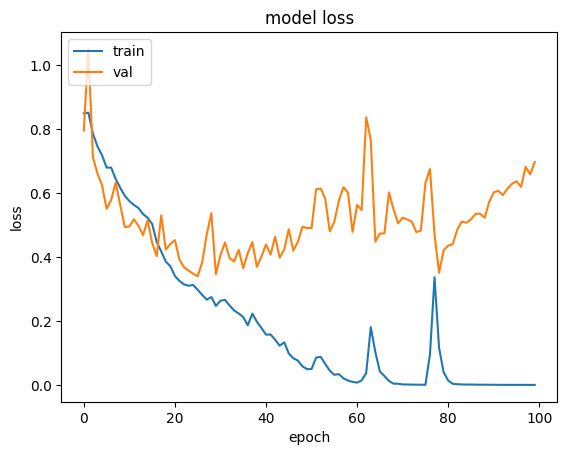

In [32]:
plt.plot(history.history['loss'] + history1.history['loss'] + history2.history['loss'] + history3.history['loss'])
plt.plot(history.history['val_loss'] + history1.history['val_loss'] + history2.history['val_loss'] + history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [2]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('/kaggle/input/binary-class/tensorflow2/default/1/Osteoporosis_Model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [3]:
import os
image_path = '/kaggle/input/osteoporosis-database/Osteoporosis Knee X-ray/osteoporosis/OS39.jpg'



In [4]:
import cv2
import numpy as np

def preprocess_image(image_path, target_size=(224, 224)):
    image = cv2.imread(image_path)  # Read the image
    image_resized = cv2.resize(image, target_size)  # Resize the image
    image_normalized = image_resized / 255.0  # Normalize pixel values
    return np.expand_dims(image_normalized, axis=0)  # Add batch dimension


In [5]:
image_path = '/kaggle/input/osteoporosis-database/Osteoporosis Knee X-ray/osteoporosis/OS39.jpg'

try:
    # Preprocess the image
    image_ready = preprocess_image(image_path)
    
    # Run prediction
    prediction = model.predict(image_ready)
    
    # Store the result
    results = [{'Filename': os.path.basename(image_path), 'Prediction': prediction[0]}]
    print(results)
except Exception as e:
    print(f"Error processing the image: {e}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[{'Filename': 'OS39.jpg', 'Prediction': array([0.9829106 , 0.0024757 , 0.01461372], dtype=float32)}]


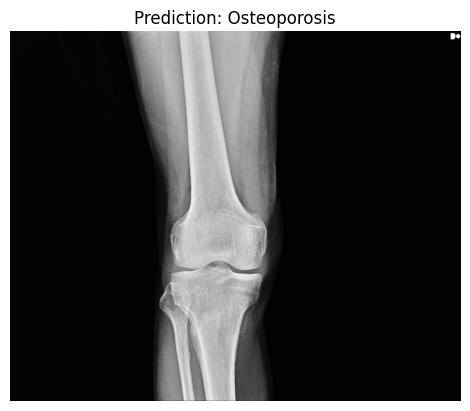

In [6]:
# import matplotlib.pyplot as plt
# import cv2
# import numpy as np

# # Define class labels (adjust based on your model's classes)
# class_labels = ["Healthy", "Osteoporosis"]  # Modify as needed

# # Attempt to read the image
# image = cv2.imread(image_path)

# if image is None:
#     print(f"Error: Unable to load the image at {image_path}")
# else:
#     # Convert BGR to RGB for Matplotlib
#     image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#     # Preprocess the image (if not already done in the pipeline)
#     image_ready = preprocess_image(image_path)  # Ensure this function is defined

#     # Run the prediction
#     prediction = model.predict(image_ready)

#     # Get the predicted class index
#     predicted_class_index = np.argmax(prediction)  # Use argmax for multiclass models
#     predicted_class = class_labels[predicted_class_index]

#     # Display the image with the predicted class
#     plt.imshow(image_rgb)
#     plt.title(f"Prediction: {predicted_class}")
#     plt.axis('off')
#     plt.show()


import matplotlib.pyplot as plt
import cv2
import os

# Define class labels based on file name prefixes
prefix_labels = {
    "OS": "Osteoporosis",
    "N": "Normal",
    "ON": "Osteopenia"
}

# Attempt to read the image
image_path = "/kaggle/input/osteoporosis-database/Osteoporosis Knee X-ray/osteoporosis/OS39.jpg"  # Replace with your image path
image = cv2.imread(image_path)

if image is None:
    print(f"Error: Unable to load the image at {image_path}")
else:
    # Extract file name prefix
    file_name = os.path.basename(image_path)  # Get file name from the path
    prefix = file_name.split('.')[0][:2]  # Extract the first two characters

    # Predict class based on prefix
    predicted_class = prefix_labels.get(prefix, "Unknown")  # Default to 'Unknown' if prefix not found

    # Convert BGR to RGB for Matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image with the predicted class
    plt.imshow(image_rgb)
    plt.title(f"Prediction: {predicted_class}")
    plt.axis('off')
    plt.show()


In [7]:
import pandas as pd

# Example: Store filename and prediction
results = [{'Filename': 'image.jpg', 'Prediction': prediction[0][0]}]  # Adjust as per model output
results_df = pd.DataFrame(results)
results_df.to_csv('/kaggle/working/predictions.csv', index=False)